In [1]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
from captum.attr import LRP

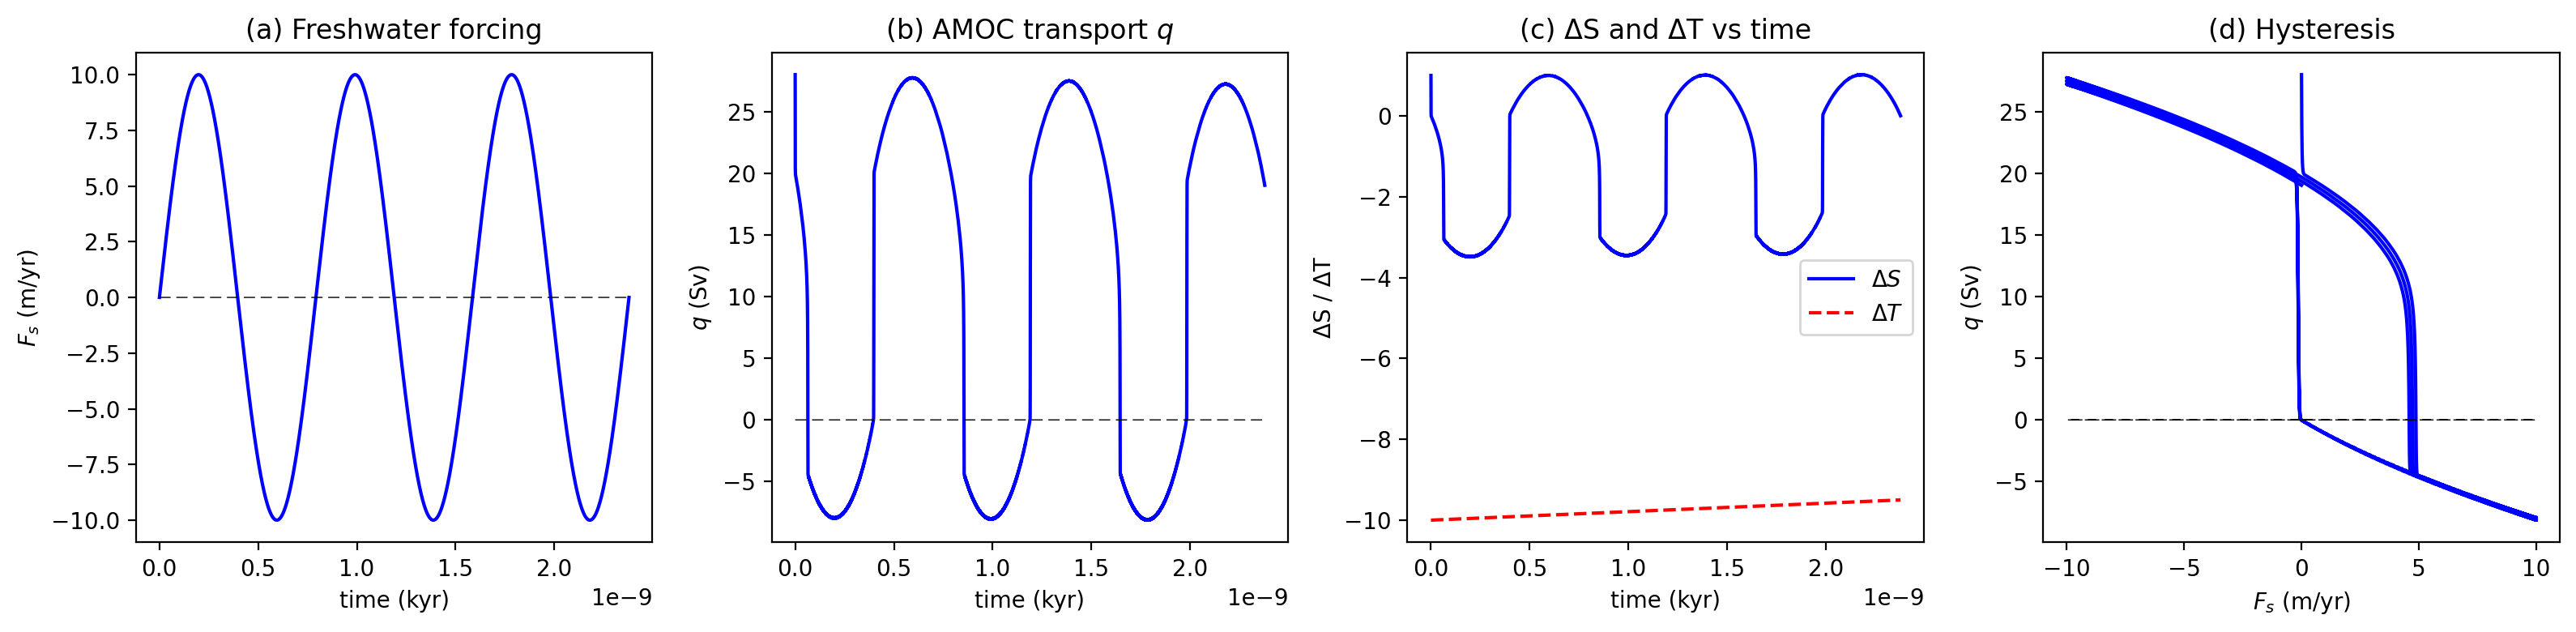

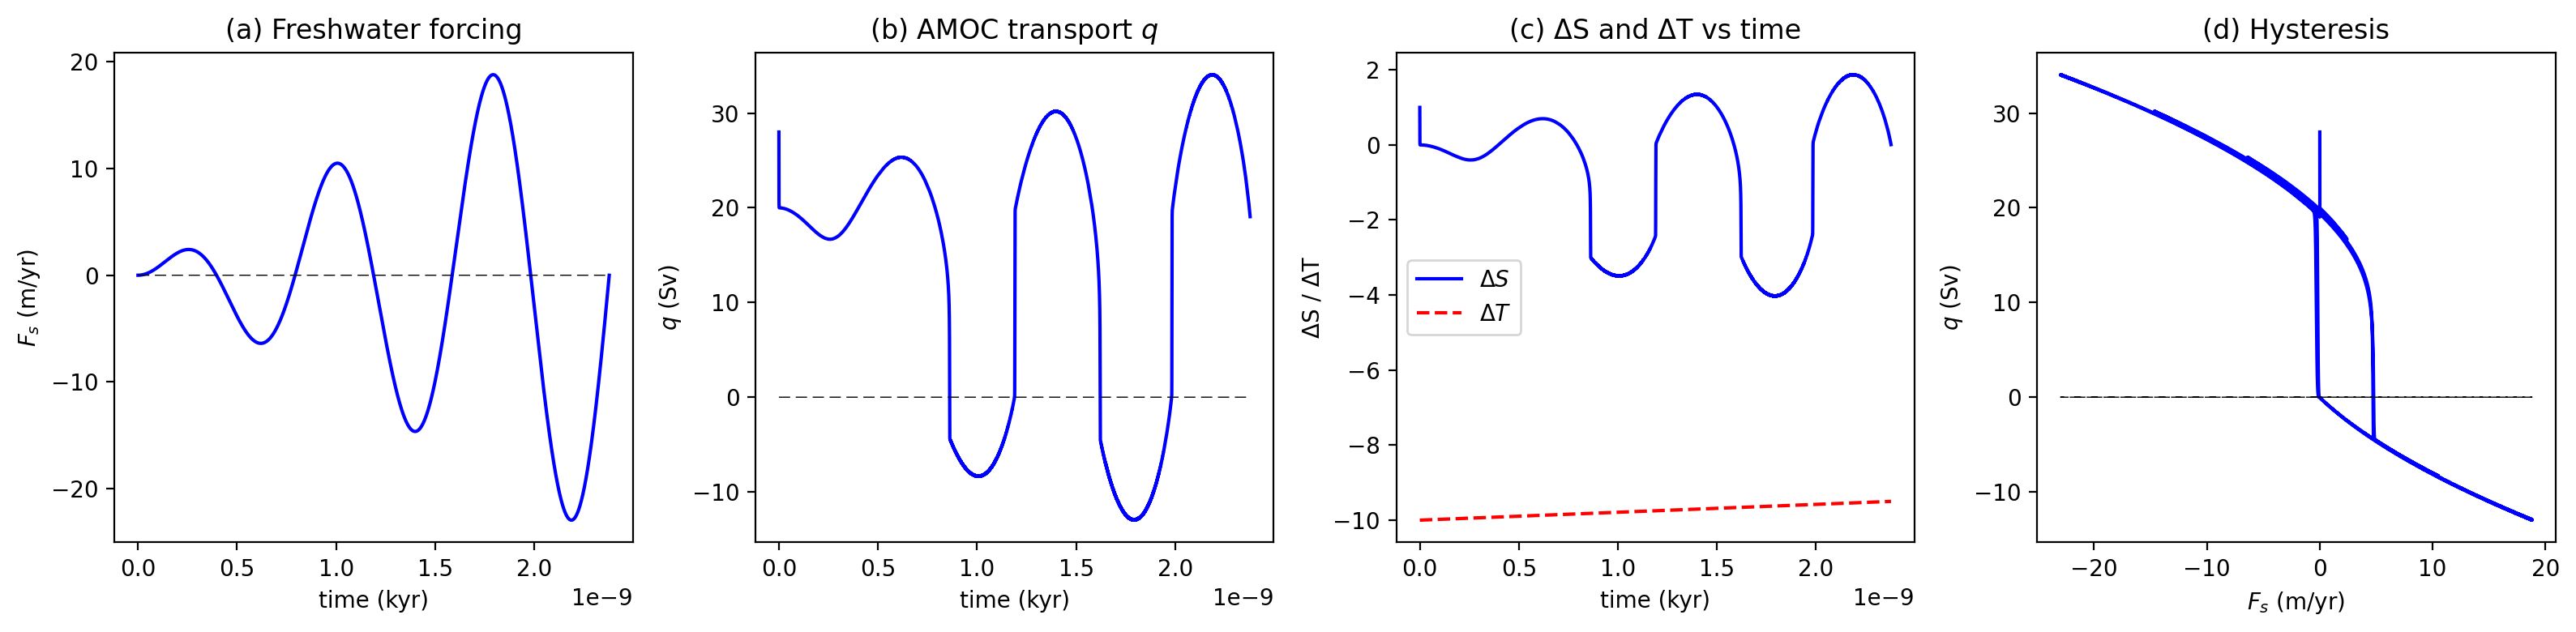

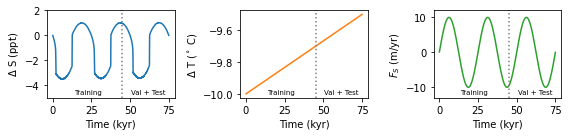

On: 70254, Off: 28743, Tipping: 940


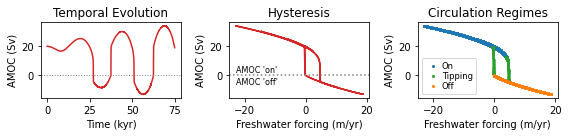

In [2]:
%run 00_generate_data.ipynb

In [3]:
input_data, output_data, qplot = get_data("s")

In [4]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

In [5]:
def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

time_steps = 16
feature_dim = 4

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

In [6]:
import numpy as np
from numpy import newaxis as na


def lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor=0.0, debug=False):
    """
    LRP for a linear layer with input dim D and output dim M.
    Args:
    - hin:            forward pass input, of shape (D,)
    - w:              connection weights, of shape (D, M)
    - b:              biases, of shape (M,)
    - hout:           forward pass output, of shape (M,) (unequal to np.dot(w.T,hin)+b if more than one incoming layer!)
    - Rout:           relevance at layer output, of shape (M,)
    - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution is redistributed for sanity check)
    - eps:            stabilizer (small positive number)
    - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore bias/stabilizer redistribution (recommended)
    Returns:
    - Rin:            relevance at layer input, of shape (D,)
    """
    sign_out = np.where(hout[na,:]>=0, 1., -1.) # shape (1, M)
    
    numer    = (w * hin[:,na]) + ( bias_factor * (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units ) # shape (D, M)
    # Note: here we multiply the bias_factor with both the bias b and the stabilizer eps since in fact
    # using the term (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units in the numerator is only useful for sanity check
    # (in the initial paper version we were using (bias_factor*b[na,:]*1. + eps*sign_out*1.) / bias_nb_units instead)
    
    denom    = hout[na,:] + (eps*sign_out*1.)   # shape (1, M)
    
    message  = (numer/denom) * Rout[na,:]       # shape (D, M)
    
    Rin      = message.sum(axis=1)              # shape (D,)
    
    if debug:
        print("local diff: ", Rout.sum() - Rin.sum())
    # Note: 
    # - local  layer   relevance conservation if bias_factor==1.0 and bias_nb_units==D (i.e. when only one incoming layer)
    # - global network relevance conservation if bias_factor==1.0 and bias_nb_units set accordingly to the total number of lower-layer connections 
    # -> can be used for sanity check
    
    return Rin

In [7]:
class LSTM_LRP:
    
    def __init__(self, i):
        model = tf.keras.models.load_model(f"models/lstm/stationary/ensemble_member_{i}.keras")
        # LSTM layer 
        lstm_layer = model.layers[0]
        # Wxh (x -> h)
        self.Wxh = lstm_layer.get_weights()[0]
        # Whh (h -> h)
        self.Whh = lstm_layer.get_weights()[1]
        # bias 
        self.b = lstm_layer.get_weights()[2]

        # Dense layers 
        self.dense1_W, self.dense1_b = model.layers[1].get_weights()
        self.dense2_W, self.dense2_b = model.layers[2].get_weights()
        self.out_W, self.out_b = model.layers[3].get_weights()
        
        # units
        self.units = lstm_layer.units
    
    def set_input(self, x):
        
        T = len(x)
        self.x = x
        self.T = T
        self.h = np.zeros((T+1, self.units))
        self.c = np.zeros((T+1, self.units))
    
    def forward(self):
        
        # gate indices
        d = self.units
        idx    = np.hstack((np.arange(0,d), np.arange(2*d,4*d))).astype(int)
        idx_i, idx_g, idx_f, idx_o = np.arange(0, d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d)
        
        # initialize
        self.gates_xh = np.zeros((self.T, 4*d))
        self.gates_hh = np.zeros((self.T, 4*d))
        self.gates_pre = np.zeros((self.T, 4*d))
        self.gates = np.zeros((self.T, 4*d))
        
        for t in range(self.T):
            # LSTM part
            self.gates_xh[t]     = np.dot(self.x[t], self.Wxh)        
            self.gates_hh[t]     = np.dot(self.h[t-1], self.Whh) 
            self.gates_pre[t]    = self.gates_xh[t] + self.gates_hh[t] + self.b
            
            self.gates[t,idx]    = 1.0/(1.0 + np.exp(-self.gates_pre[t,idx]))
             
            self.gates[t,idx_g]  = np.tanh(self.gates_pre[t,idx_g]) 
            self.c[t]            = self.gates[t,idx_f]*self.c[t-1] + self.gates[t,idx_i]*self.gates[t,idx_g]
            self.h[t]            = self.gates[t,idx_o]*np.tanh(self.c[t])
            
        # Dense part 
        self.a1 = np.maximum(0, np.dot(self.h[self.T-1], self.dense1_W) + self.dense1_b)  # ReLU
        self.a2 = np.maximum(0, np.dot(self.a1, self.dense2_W) + self.dense2_b)           # ReLU
        self.y = np.dot(self.a2, self.out_W) + self.out_b # linear output
        self.z = 1 / (1 + np.exp(-self.y)) # sigmoid 
        
        return self.z.copy()
        #return self.y.copy()
    
    def lrp(self, x, eps=1e-6, bias_factor=0.0):
        
        # forward pass 
        self.set_input(x)
        self.forward()
        
        # sequence length and units
        T = self.T 
        d = self.units
        e = 4
        
        # Gate indices
        idx = np.hstack((np.arange(0,d), np.arange(2*d,4*d)))  # i,f,o
        idx_i, idx_g, idx_f, idx_o = np.arange(0,d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d)
        
        # going backwards so first output
        R_out = self.y.copy()  # linear output 

        # next, dense layers
        R2 = lrp_linear(self.a2, self.out_W, self.out_b, self.y, R_out, self.a2.size, eps, bias_factor)
        R1 = lrp_linear(self.a1, self.dense2_W, self.dense2_b, self.a2, R2, self.a1.size, eps, bias_factor)
        Rh = lrp_linear(self.h[T-1], self.dense1_W, self.dense1_b, self.a1, R1, self.h[T-1].size, eps, bias_factor)

        # lstm layer
        Rx = np.zeros_like(self.x)
        Rc = np.zeros((T+1, d))
        Rg = np.zeros((T, d))
        Rh_t = np.zeros((T+1, d))
        Rh_t[T-1] = Rh

        for t in reversed(range(T)):
            Rc[t] += Rh_t[t]
            Rc[t-1] = lrp_linear(
                self.gates[t, idx_f] * self.c[t-1],
                np.identity(d),
                np.zeros(d),
                self.c[t],
                Rc[t],
                2*d,
                eps,
                bias_factor
            )
            Rg[t] = lrp_linear(
                self.gates[t, idx_i] * self.gates[t, idx_g],
                np.identity(d),
                np.zeros(d),
                self.c[t],
                Rc[t],
                2*d,
                eps,
                bias_factor
            )

            # Input x relevance (fix: axis 1 of Wxh)
            Rx[t] = lrp_linear(
                self.x[t],
                self.Wxh[:, idx_g],
                self.b[idx_g],
                self.gates_pre[t, idx_g],
                Rg[t],
                d+e,
                eps,
                bias_factor
            )

            # Previous hidden relevance (fix: axis 1 of Whh)
            Rh_t[t-1] = lrp_linear(
                self.h[t-1],
                self.Whh[:, idx_g],
                self.b[idx_g],
                self.gates_pre[t, idx_g],
                Rg[t],
                d+e,
                eps,
                bias_factor
            )

        return Rx

In [8]:
# testing if forward does the same thing as keras model 

In [9]:
keras_model = tf.keras.models.load_model(f"models/lstm/stationary/ensemble_member_0.keras")
keras_preds = keras_model(input_seq)

In [19]:
keras_preds.numpy().squeeze()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [24]:
class LSTM_LRP:
    def __init__(self, i):
        # Load Keras model
        model = tf.keras.models.load_model(f"models/lstm/stationary/ensemble_member_{i}.keras")
        
        lstm_layer = model.layers[0]
        self.Wxh = lstm_layer.get_weights()[0]  # (input_dim, 4*units)
        self.Whh = lstm_layer.get_weights()[1]  # (units, 4*units)
        self.b = lstm_layer.get_weights()[2]    # (4*units,)
        
        # Dense layers
        self.dense1_W, self.dense1_b = model.layers[1].get_weights()
        self.dense2_W, self.dense2_b = model.layers[2].get_weights()
        self.out_W, self.out_b       = model.layers[3].get_weights()
        
        self.units = lstm_layer.units
    
    def set_input(self, x):
        self.x = x
        self.T = len(x)
        self.h = np.zeros((self.T+1, self.units))
        self.c = np.zeros((self.T+1, self.units))
    
    def forward(self, x):
        self.set_input(x)
        T, d = self.T, self.units
        
        # Gate indices for Keras LSTM: i, f, c, o
        idx_i = np.arange(0, d)
        idx_f = np.arange(d, 2*d)
        idx_c = np.arange(2*d, 3*d)
        idx_o = np.arange(3*d, 4*d)
        
        self.gates_pre = np.zeros((T, 4*d))
        self.gates = np.zeros((T, 4*d))
        
        for t in range(T):
            # Linear combination
            self.gates_pre[t] = np.dot(self.x[t], self.Wxh) + np.dot(self.h[t-1], self.Whh) + self.b
            
            # Activation
            self.gates[t, idx_i] = 1 / (1 + np.exp(-self.gates_pre[t, idx_i]))  # input gate
            self.gates[t, idx_f] = 1 / (1 + np.exp(-self.gates_pre[t, idx_f]))  # forget gate
            self.gates[t, idx_o] = 1 / (1 + np.exp(-self.gates_pre[t, idx_o]))  # output gate
            self.gates[t, idx_c] = np.tanh(self.gates_pre[t, idx_c])             # cell gate
            
            # Cell and hidden states
            self.c[t] = self.gates[t, idx_f]*self.c[t-1] + self.gates[t, idx_i]*self.gates[t, idx_c]
            self.h[t] = self.gates[t, idx_o]*np.tanh(self.c[t])
        
        # Dense layers
        self.a1 = np.maximum(0, np.dot(self.h[T-1], self.dense1_W) + self.dense1_b)
        self.a2 = np.maximum(0, np.dot(self.a1, self.dense2_W) + self.dense2_b)
        self.y = np.dot(self.a2, self.out_W) + self.out_b   # linear output
        
        # Sigmoid for forward prediction
        self.z = 1 / (1 + np.exp(-self.y))
        return self.z.copy()  # matches Keras predictions
    
    def lrp(self, x, eps=1e-6, bias_factor=1.0):
        # Forward pass
        self.set_input(x)
        self.forward(x)
        
        # LRP should use linear output
        R_out = self.y.copy()
        T, d = self.T, self.units
        
        # Step 1: Dense layers
        R2 = lrp_linear(self.a2, self.out_W, self.out_b, self.y, R_out, self.a2.size, eps, bias_factor)
        R1 = lrp_linear(self.a1, self.dense2_W, self.dense2_b, self.a2, R2, self.a1.size, eps, bias_factor)
        Rh = lrp_linear(self.h[T-1], self.dense1_W, self.dense1_b, self.a1, R1, self.h[T-1].size, eps, bias_factor)
        
        # Step 2: LSTM backward (simplified version)
        Rx = np.zeros_like(self.x)
        Rc = np.zeros((T+1, d))
        Rh_t = np.zeros((T+1, d))
        Rh_t[T-1] = Rh
        
        idx_i = np.arange(0, d)
        idx_f = np.arange(d, 2*d)
        idx_c = np.arange(2*d, 3*d)
        idx_o = np.arange(3*d, 4*d)
        
        for t in reversed(range(T)):
            Rc[t] += Rh_t[t]
            
            # Forget and input gates
            Rc[t-1] = lrp_linear(self.gates[t, idx_f]*self.c[t-1], np.identity(d), np.zeros(d), self.c[t], Rc[t], d, eps, bias_factor)
            Rg = lrp_linear(self.gates[t, idx_i]*self.gates[t, idx_c], np.identity(d), np.zeros(d), self.c[t], Rc[t], d, eps, bias_factor)
            
            # Input relevance
            Rx[t] = lrp_linear(self.x[t], self.Wxh[:, idx_c], self.b[idx_c], self.gates_pre[t, idx_c], Rg, d, eps, bias_factor)
            
            # Previous hidden relevance
            Rh_t[t-1] = lrp_linear(self.h[t-1], self.Whh[:, idx_c], self.b[idx_c], self.gates_pre[t, idx_c], Rg, d, eps, bias_factor)
        
        return Rx


In [12]:
model_lrp = LSTM_LRP(0)
custom_preds = np.array([model_lrp.forward(x) for x in input_seq])
keras_preds = keras_model(input_seq).numpy()
np.max(np.abs(custom_preds - keras_preds))

7.602328529476843e-07

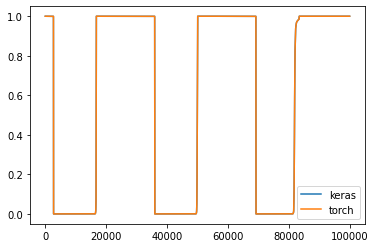

In [20]:
plt.plot(keras_preds, label='keras')
plt.plot(custom_preds, label='torch')
plt.legend()

In [25]:
model_lrp = LSTM_LRP(0)

In [26]:
model_lrp.lrp(input_seq[0])

array([[-9.23335948e+08, -2.04594206e+09,  6.23842653e+08,
        -1.27457878e+08],
       [-7.45470527e+08, -1.46868547e+09,  5.26139236e+08,
        -8.71968167e+07],
       [-6.75655177e+08, -1.23954582e+09,  4.93766061e+08,
        -7.24466241e+07],
       [-6.22424168e+08, -1.11798740e+09,  4.69131976e+08,
        -6.69615084e+07],
       [-5.70124714e+08, -1.05270375e+09,  4.44971886e+08,
        -6.69855718e+07],
       [-4.55934145e+08, -9.89000285e+08,  3.87738691e+08,
        -7.02131398e+07],
       [-7.40185114e+08, -1.16539600e+09,  5.48982706e+08,
        -7.76694061e+07],
       [-8.75566638e+08, -1.28226374e+09,  6.34932278e+08,
        -8.86500764e+07],
       [-1.00421250e+09, -1.40548320e+09,  7.21589273e+08,
        -1.02075170e+08],
       [-1.14224399e+09, -1.54067549e+09,  8.17935959e+08,
        -1.17793557e+08],
       [-1.29679394e+09, -1.68978586e+09,  9.28322976e+08,
        -1.35848495e+08],
       [-1.47358522e+09, -1.85404333e+09,  1.05657168e+09,
      

In [ ]:
def sigmoid_inverse(y):
    """
    Invert sigmoid: given sigmoid output y, return the pre-activation input
    sigmoid(x) = 1 / (1 + exp(-x))
    inverse: x = log(y / (1 - y))
    """
    return np.log(y / (1 - y))

In [18]:
output_data.shape

(100000,)

In [482]:
num_ensembles = 12
num_samples = len(input_seq)
time_steps = input_seq.shape[1]  # sequence length
num_features = input_seq.shape[2]

# Pre-allocate the full relevance array
Rx_all = np.zeros((num_ensembles, num_samples, time_steps, num_features))

for i in range(num_ensembles):
    model_lrp = LSTM_LRP(i)
    
    # Pre-allocate for this ensemble member
    Rx_ensemble_i = np.zeros((num_samples, time_steps, num_features))
    
    for j, x in enumerate(input_seq):
        Rx_ensemble_i[j] = model_lrp.lrp(x)  # lrp internally calls set_input + forward
    
    Rx_all[i] = Rx_ensemble_i

In [483]:
np.save('lrp_manual_lstm', Rx_all)

In [484]:
Rx_all.shape

(12, 99985, 16, 4)

In [485]:
Rx_mean = Rx_all.mean(axis=0)

In [486]:
Rx_mean.shape

(99985, 16, 4)

In [487]:
Rx_mean_time = Rx_mean.mean(axis=1)

In [488]:
lrp_sal_mean_t = Rx_mean_time[:, 1]
lrp_temp_mean_t = Rx_mean_time[:, 2]

Text(0, 0.5, 'relevance')

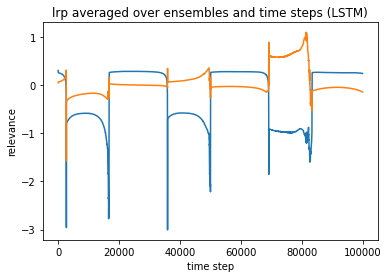

In [489]:
plt.plot(lrp_sal_mean_t, label='salinity lrp')
plt.plot(lrp_temp_mean_t, label='temp lrp')
plt.title('lrp averaged over ensembles and time steps (LSTM)')
plt.xlabel('time step')
plt.ylabel('relevance')

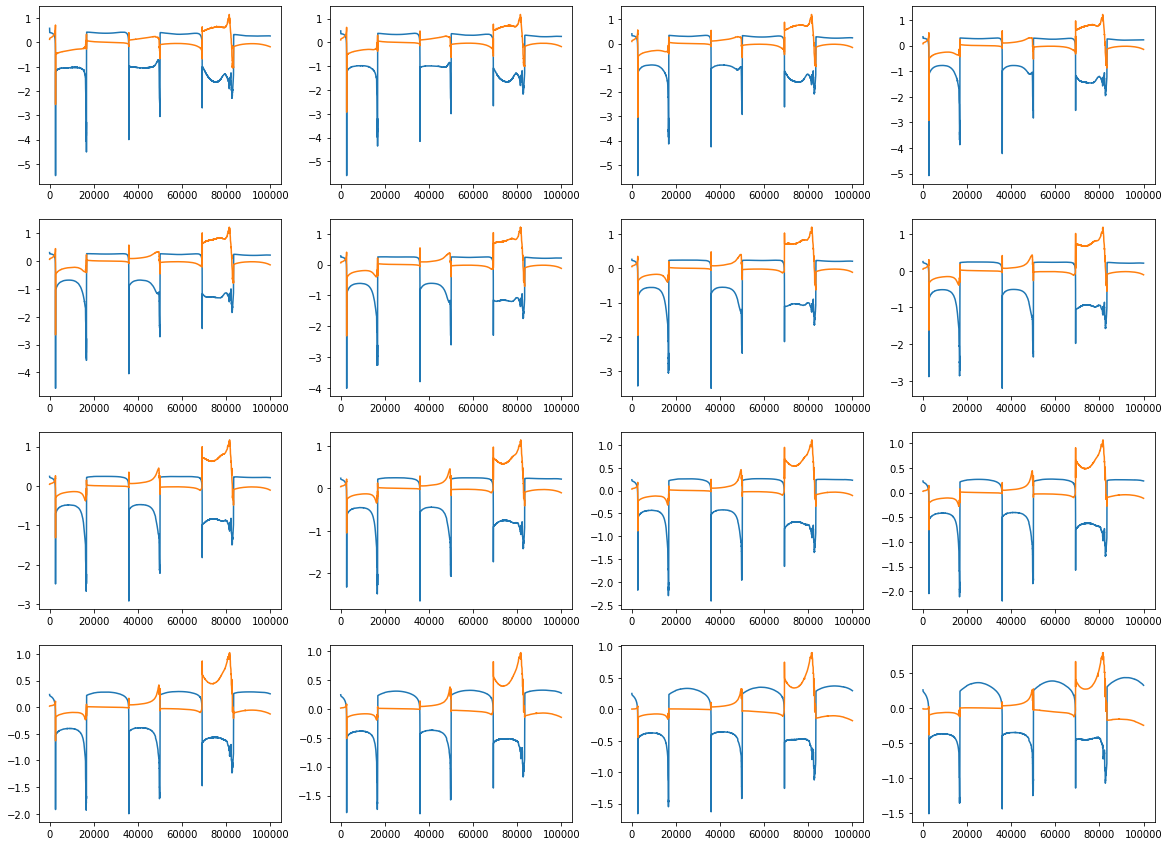

In [497]:
fig, ax = plt.subplots(4, 4, figsize=(20, 15));
ax = ax.flatten();
for i in range(16):
    ax[i].plot(Rx_mean[:, i, 1], label='salinity lrp');
    ax[i].plot(Rx_mean[:, i, 2], label='temp lrp');
fig.savefig('all.png')

Text(0, 0.5, 'relevance')

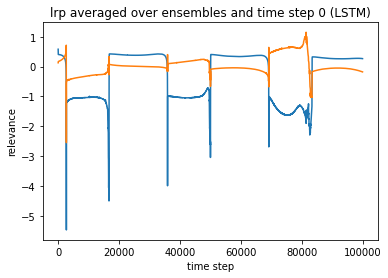

In [490]:
plt.plot(Rx_mean[:, 0, 1], label='salinity lrp')
plt.plot(Rx_mean[:, 0, 2], label='temp lrp')
plt.title('lrp averaged over ensembles and time step 0 (LSTM)')
plt.xlabel('time step')
plt.ylabel('relevance')

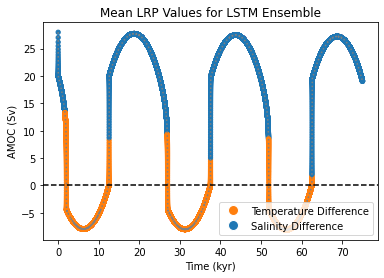

In [493]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(lrp_temp_mean_t > lrp_sal_mean_t, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(input_data[:99985, 0], qplot[:99985]/Sv, 
                    c=colors, marker='o', s=18)

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('Mean LRP Values for LSTM Ensemble')
ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')

In [422]:
x_input = input_seq[0]

In [423]:
x_input.shape

(16, 4)

In [424]:
model_lrp.set_input(x_input)

In [425]:
y_pred = model_lrp.forward()

In [426]:
y_pred

array([0.99535329])

In [427]:
model = tf.keras.models.load_model(f"models/lstm/stationary/ensemble_member_0.keras")
model.predict(x_input)

In [430]:
x_input.shape

(16, 4)

In [431]:
x_input_batch = x_input[None, :, :]  # shape (1, T, F)
y_pred_keras = model.predict(x_input_batch)

1/1 [==============================] - 0s 328ms/step


In [432]:
y_pred_keras

array([[0.9999904]], dtype=float32)

In [416]:
Rx = model_lrp.lrp(x_input)

In [417]:
Rx

array([[-0.00048132,  0.01467671,  0.00120531,  0.00068013],
       [-0.00111078,  0.01736101,  0.00222477,  0.00082047],
       [-0.0022792 ,  0.01993753,  0.00342284,  0.00098662],
       [-0.00405993,  0.02297131,  0.00496949,  0.00120041],
       [-0.00648881,  0.02676734,  0.00694233,  0.00147422],
       [-0.00969927,  0.03151656,  0.00940394,  0.00181852],
       [-0.0139268 ,  0.0374659 ,  0.01245181,  0.00224804],
       [-0.01945821,  0.04491782,  0.0161403 ,  0.00277723],
       [-0.02660404,  0.05423936,  0.02041279,  0.00341676],
       [-0.03559268,  0.06582567,  0.0249615 ,  0.00416646],
       [-0.04623935,  0.07999326,  0.0289979 ,  0.00500749],
       [-0.05696939,  0.09672895,  0.03092319,  0.00590559],
       [-0.06219676,  0.11518977,  0.02802417,  0.00687162],
       [-0.04603221,  0.13266931,  0.01669555,  0.00823082],
       [ 0.03004177,  0.14146839, -0.0055637 ,  0.01158348],
       [ 0.23796809,  0.11366739, -0.03508793,  0.02310324]])

In [373]:
lrp_all = []

In [374]:
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

# Number of sequences available
num_sequences = input_seq.shape[0]

# Compute gradient for each sequence (using last value or mean)
qplot_smooth = qplot / Sv
seq_grad = np.array([
    np.mean(np.abs(np.gradient(qplot_smooth[i:i+time_steps])))
    for i in range(num_sequences)
])

# Sampling probabilities
seq_probs = seq_grad / seq_grad.sum()

# Sample start indices
sample_size = 250
sample_start_indices = np.random.choice(num_sequences, size=sample_size, replace=False, p=seq_probs)

# Extract sequences
input_samples = input_seq[sample_start_indices]
output_samples = output_seq[sample_start_indices]

In [375]:
num_samples = 250
T, F = 16, 4  # sequence length, feature dimension
lrp_all = np.zeros((num_samples, T, F))

for i in range(num_samples):
    #model_lrp.set_input(input_samples[i])  # input_samples[i] shape (T, F)
    #model_lrp.forward()
    Rx = model_lrp.lrp(input_samples[i])
    lrp_all[i] = Rx  # assign to slice

In [376]:
lrp_mean = lrp_all.mean(axis=1)

In [377]:
lrp_sal = lrp_mean[:, 1]
lrp_temp = lrp_mean[:, 2]

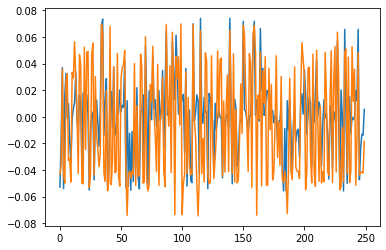

In [378]:
plt.plot(lrp_temp)
plt.plot(lrp_sal)

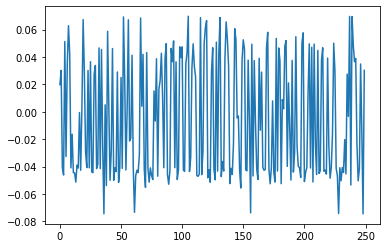

In [328]:
plt.plot(lrp_sal)

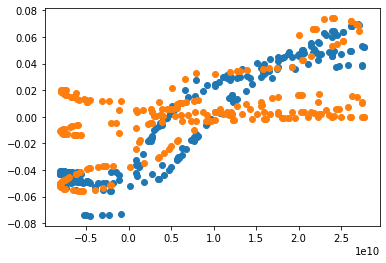

In [379]:
plt.scatter(qplot[sample_start_indices], lrp_sal)
plt.scatter(qplot[sample_start_indices], lrp_temp)

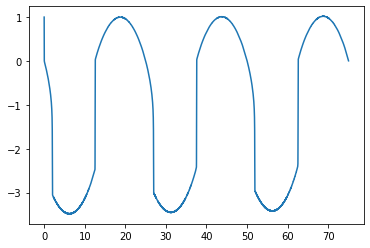

In [380]:
plt.plot(input_data[:, 0], input_data[:, 1])

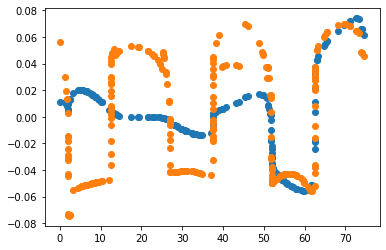

In [389]:
plt.scatter(input_data[sample_start_indices, 0], lrp_temp)
plt.scatter(input_data[sample_start_indices, 0], lrp_sal)

In [382]:
lrp_0 = lrp_all[:, 3, :]

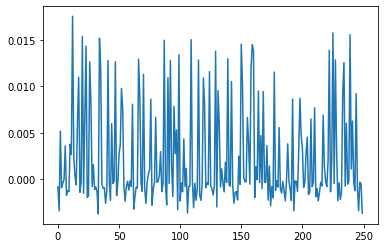

In [383]:
plt.plot(lrp_0[:, 1])

In [384]:
input_data[sample_start_indices, 0].shape

(250,)

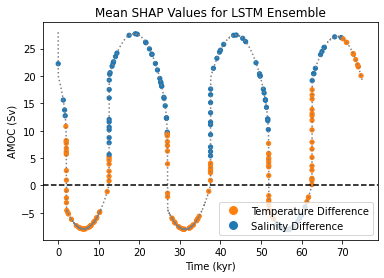

In [385]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(lrp_temp > lrp_sal, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(input_data[sample_start_indices, 0], qplot[sample_start_indices]/Sv, 
                    c=colors, marker='o', s=18)

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('Mean SHAP Values for LSTM Ensemble')
ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')